# Módulo 3. Redes neuronales avanzadas

¡Bienvenidos al tercer módulo! Tras el último módulo donde aprendimos como funcionan realmente las redes neuronales (espero que todos recordeis el backpropagation), en este módulo vamos a implementar y optimizar la segunda red neuronal, además de adentrarnos a la libreria keras, que nos facilitará mucho el desarrollo de redes neuronales.



## 1. División de los datos

En general, los algoritmos de Machine Learning aprenden de los datos con los que los entrenamos. A partir de ellos, intentan encontrar o inferir el patrón que les permita predecir el resultado para un nuevo caso. Pero, para poder calibrar si un modelo funciona, necesitaremos probarlo con un conjunto de datos **diferente**. ¿Qué pasaría si entrenamos y validamos el modelo con los mismos datos? Tendríamos, unos muy buenos resultados en la validación, pero realmente, ¿el modelo sería capaz de generalizar tan bien?

Por tanto, en todo proceso de aprendizaje automático, los datos se deben dividir en tres partes: datos de entrenamiento, datos de validación y datos test.

* **Entrenamiento**: son utilizados para actualizar los pesos cada batch.
* **Validación**: comprueba la capacidad de generalización de la red en cada época-> prueba con muestras que no ha visto durante el entrenamiento, sirve para monitorizar el entrenamiento de la red a titulo informativo, pero, ¡no interviene en ningún cálculo! Suele emplearse cuando se quieren ajustar los parámetros, siendo este conjunto el que indica qué parámetros es mejor utilizar. A más accuracy en validación, mejor set de parámetros tenemos. Por este motivo, no podemos confiar en este resultado para hacernos una idea de la capacidad de generalización de la red, porque hemos elegido la configuración de la red para que nos de un accuracy más alto. Por lo cual, debemos tener un conjunto extra que nos permita, ahora sí, decir si nuestra red es buena con muestras que no haya visto nunca o no: el de test.

* **Test**: nos da una intuición de lo buena que es nuestra red al generalizar con un conjunto (más grande que el de validación) nunca visto.

Veamos las proporciones que se suelen utilizar de cada tipo:

<center> <a href="https://ibb.co/0XgNYBV"><img src="https://i.ibb.co/1nDVRsJ/particion-datos.png" alt="IA engloba ML, que a su vez engloba DL" border="0"> </center> </a>

---

### **Recordatorio: K-Fold Cross-Validation**

<center> <a href="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png"><img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="K-Fold Cross-Val" border="0"> </center> </a>



Para las implementaciones de las redes neuronales que vamos a realizar hoy, vamos a seguir trabajando con el set de datos **MNIST**. Como ya sabéis, el set de datos **MNIST** es un conjunto de  70000 imágenes de $28 \times 28$ pixels que contienen números manuscritos junto con la etiqueta solución del número codificado (i.e. nuestro ground truth). Cabe destacar que, por convención, MNIST dispone de una división específica en conjuntos de entrenamiento, validación y test.  Así que sin más dilación vamos a cargar los datos y a visuar las particiones llevadas a cabo:


El conjunto de entrenamiento tiene dimensiones:  (51000, 28, 28)
El conjunto de validación tiene dimensiones:  (9000, 28, 28)
El conjunto de test tiene dimensiones:  (10000, 28, 28)


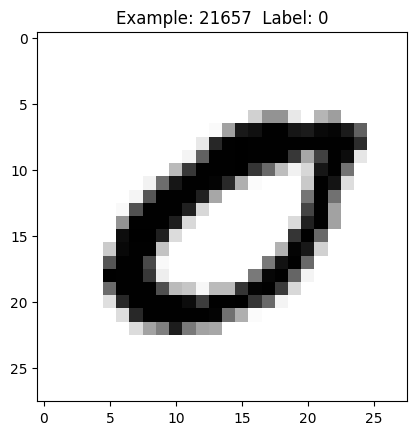

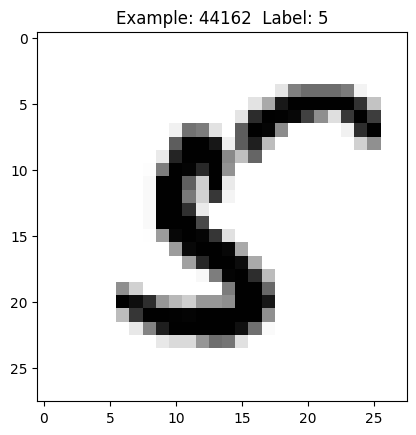

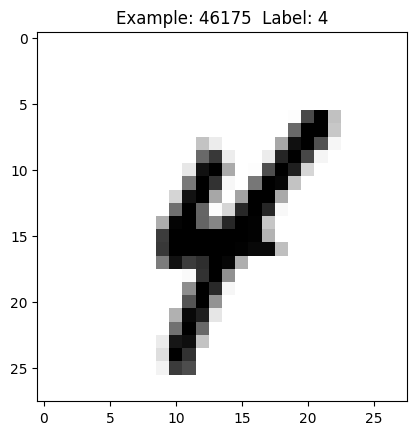

In [5]:
# Imports necesarios
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Importamos el dataset MNIST y cargamos los datos
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15)

# Comprobar el tamaño del dataset
print("El conjunto de entrenamiento tiene dimensiones: ", x_train.shape)
print("El conjunto de validación tiene dimensiones: ",x_val.shape)
print("El conjunto de test tiene dimensiones: ",x_test.shape)

# Método para visualizar los datos de entrenamiento
def display_digit(num):
  # Seleccionar la imagen num de imagenes de train
  image = x_train[num,:,:]
  # Seleccionar el target num de y_train (Recuerda que esta en one-hot encoding, conviertelo a decimal con argmax)
  label = y_train[num] #(X)
  # Mostrar
  plt.title('Example: %d  Label: %d' % (num, label))
  plt.imshow(image, cmap=plt.get_cmap('gray_r'))
  plt.show()

# Mostramos algunos ejemplos
display_digit(np.random.randint(0, x_train.shape[0]))
display_digit(np.random.randint(0, x_train.shape[0]))
display_digit(np.random.randint(0, x_train.shape[0]))

# Ejecuta el código varias veces y comprueba la variabilidad existente en los datos

Una vez visualizadas ciertas muestras de nuestro conjunto de datos,  vamos a volver a entrenar el **perceptrón simple** de la sesión anterior teniendo en cuenta el conjunto de entrenamiento, validación y test. Recordad que en el perceptrón simple las entradas se ponderan por ciertos pesos y se suman en cada una de las neuronas de salida. Posteriormente emplearemos la función **Softmax** que hemos explicado en la sesión teórica, calculando las predicciones como $\hat{Y}=softmax(X∗W+B)$ y minimizando la función de entropía cruzada o **cross-entropy** siguiendo la formula:

>>>>>>>>$Coste = - \displaystyle\sum_j y_j log(p_j)$

donde $y_j$ es el *ground truth* para la clase $j$ y $p_j$ el valor de probabilidad asignado a dicha clase a la salida.

In [6]:
# Hiper-parámetros de nuestra red
lr = 0.01
n_epochs = 20
batch_size = 128

x_train = x_train / 255.
x_test = x_test / 255.
x_val= x_val / 255.


# 1. Convertimos las imágenes a vectores, dado que aún no hemos visto cómo podemos implementar un modelo que trabaje con imágenes
x_train = tf.reshape(x_train, shape=(51000, -1)) # Nuestros datos ya están en formato [N_instancias, variables] (60000 instancias, 784 (28+28) pixels).
x_val = tf.reshape(x_val, shape=(9000, -1)) # Nuestros datos ya están en formato [N_instancias, variables] (9000 instancias, 784 (28+28) pixels).
x_test = tf.reshape(x_test, shape=(10000, -1)) # Nuestros datos ya están en formato [N_instancias, variables] (10000 instancias, 784 (28+28) pixels).


# 2. Convertimos las etiquetas a one-hot y a float 64 ya que todos los datos deben estar en el mismo formato

#Datos a one-hot-encoding
y_train = tf.one_hot(y_train, depth=10)
y_val = tf.one_hot(y_val, depth=10)
y_test = tf.one_hot(y_test, depth=10)

#Datos en el mismo formato
y_train = tf.cast(y_train, 'float64')
y_val= tf.cast(y_val, 'float64')
y_test = tf.cast(y_test, 'float64')

training_subset = 500
x_train = x_train[:training_subset]
y_train = y_train[:training_subset]

#3. Nos creamos ahora el iterador para que recorra nuestro dataset. Podéis leer más sobre tf.data aquí: https://www.tensorflow.org/guide/data
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(10000).batch(batch_size)

#4. Calculamos las iteraciones por época
total_batch = x_train.shape[0] // batch_size

#5. Creamos e inicializamos con ceros las variables W y b
W = tf.zeros([784, 10], tf.double)
b = tf.zeros([10], tf.double)

# para almacenar el histórico de costes
acc_epoch_tr = []
acc_epoch_val = []
loss_epoch_tr = []
loss_epoch_val = []

# entrenamiento de nuestra red
for epoch in range(n_epochs):
    avg_loss = 0.
    avg_acc = 0.

    for batch_xs, batch_ys in train_ds:
        # Empezamos con la optimización
        # haremos uso de tf.GradientTape, que lleva un control de las variables
        # para poder calcular sus gradientes
        with tf.GradientTape() as tape:
            # le indicamos que "vigile" las variables a optimizar
            tape.watch(W)
            tape.watch(b)

            # ejecutamos el modelo
            pred = tf.nn.softmax(tf.matmul(batch_xs, W) + b)
            # calculamos el accuracy (precisión)
            correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(batch_ys, 1))
            acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            # Ahora, definimos nuestra función de pérdidas: esta vez, la cros-entropía
            cost = tf.reduce_mean(-tf.reduce_sum(batch_ys*tf.math.log(pred), axis=1))
            # calculamos los gradientes (gradient descent)
            grad_W, grad_b = tape.gradient(cost, [W, b])

            # definimos las operaciones para actualizar los pesos con los gradientes calculados
            # y el learning rate
            W = W - lr * grad_W
            b = b - lr * grad_b

        # calculamos las perdidas y el accuracy teniendo en cuenta los batches que hay
        avg_loss += cost / total_batch
        avg_acc += acc / total_batch

    val_pred = tf.nn.softmax(tf.matmul(x_val, W) + b)
    val_loss = tf.reduce_mean(-tf.reduce_sum(y_val*tf.math.log(val_pred), axis=1))
    val_correct = tf.equal(tf.argmax(val_pred, 1), tf.argmax(y_val, 1))
    val_acc = tf.reduce_mean(tf.cast(val_correct, tf.float32))
    acc_epoch_tr.append(avg_acc)
    acc_epoch_val.append(val_acc)
    loss_epoch_tr.append(avg_loss)
    loss_epoch_val.append(val_loss)
    print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(avg_loss), "accuracy=", "{:.9f}".format(avg_acc), "val_loss=", "{:.9f}".format(val_loss), "val_accuracy=", "{:.9f}".format(val_acc))

Epoch: 0001 loss= 3.049877882 accuracy= 0.447018683 val_loss= 2.262220051 val_accuracy= 0.394777775
Epoch: 0002 loss= 2.990503745 accuracy= 0.647629380 val_loss= 2.223557356 val_accuracy= 0.431444436
Epoch: 0003 loss= 2.933177801 accuracy= 0.653376400 val_loss= 2.185969639 val_accuracy= 0.472666681
Epoch: 0004 loss= 2.879689681 accuracy= 0.691720545 val_loss= 2.149469938 val_accuracy= 0.502555549
Epoch: 0005 loss= 2.826707772 accuracy= 0.783495009 val_loss= 2.114407186 val_accuracy= 0.519999981
Epoch: 0006 loss= 2.775015490 accuracy= 0.776760042 val_loss= 2.080111611 val_accuracy= 0.539333344
Epoch: 0007 loss= 2.727437515 accuracy= 0.820761502 val_loss= 2.046991169 val_accuracy= 0.558666646
Epoch: 0008 loss= 2.679979159 accuracy= 0.814655185 val_loss= 2.014527955 val_accuracy= 0.579666674
Epoch: 0009 loss= 2.634245540 accuracy= 0.873024404 val_loss= 1.983042113 val_accuracy= 0.597777784
Epoch: 0010 loss= 2.587543847 accuracy= 0.910380721 val_loss= 1.952225285 val_accuracy= 0.612888873


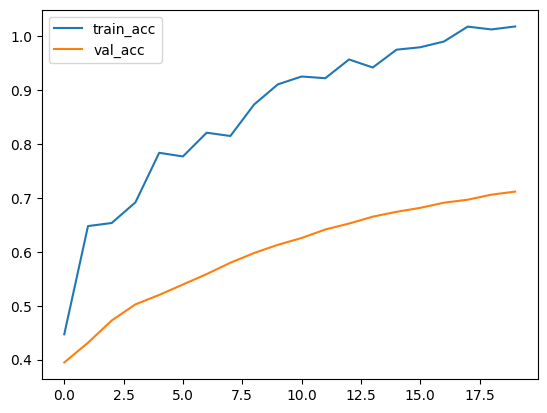

In [7]:
plt.figure()
plt.plot(np.arange(0, n_epochs), acc_epoch_tr, label="train_acc")
plt.plot(np.arange(0, n_epochs), acc_epoch_val, label="val_acc")
plt.legend()
plt.show()

## 2. Librería Keras
Después de trabajar durante estas sesiones con la librería de bajo nivel denominada TensorFlow, en el presente módulo se va a introducir un framework de alto nivel para el entrenamiento de redes neuronales denominado **Keras**. Esta librería fue desarrollada por **François Chollet** en 2015 con el objetivo de **simplificar la programación de algoritmos basados en aprendizaje profundo** ofreciendo un conjunto de abstracciones más intuitivas y de alto nivel. Keras hace uso de librerías de más bajo nivel o ***backend*** por detrás, concretamente se puede escoger entre **TensorFlow,  Microsoft Cognitive Toolkit o Theano**. Durante las siguientes sesiones haremos uso de la librería Keras con TensorFlow como backend.

Cabe destacar que en keras, existen dos formas de generar la arquitectura de un modelo:

*   **Modo (o API) secuencial**: Se instancia un objeto del tipo Model y a este se le van añadiendo las capas que conforman la arquitectura una
detrás de otra.

*   **Modo (o API) funcional**: Se define una entrada y a partir de las mismas
se va definiendo la arquitectura indicando cuál es la entrada a cada
capa) Una vez definida la arquitectura se crea el objeto modelo
pasándole las entradas y las salidas (última capa definida).


En primer lugar y con el objetivo de familiarizarnos con esta nueva librería, el primer ejercicio de esta sección consistirá en replicar el perceptron simple desarrollado en el último ejercicio (pero esta vez **empleando Keras** en vez de TensorFlow.  Si recordaís  el objetivo que perseguía la práctica anterior era el de **clasificar el dataset de dígitos manuscritos denominado MNIST**, así que vamos a ello:

Como siempre, lo primero que tenemos que hacer es cargar los datos:

In [6]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import ## Code ##

# Importamos el dataset MNIST desde Keras datasets y cargamos los datos #(X)
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_te, y_te) = mnist.load_data()
# Normalizamos los datos en el rango de 0-1 para que computacionalmente sea más eficiente el proceso #(X)
x_train, x_te = x_train / 255.0, x_te / 255.0
# Pasamos a etiquetas one-hot encoded #(X)
y_train = ## Code ##
y_te = ## Code ##
# Dividimos el conjunto de training en training y validation #(X)
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

SyntaxError: invalid syntax (ipython-input-4196557950.py, line 3)

In [ ]:
# Imports necesarios
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.models import ## Code ##
from tensorflow.keras.layers import ## Code ##
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Hiper-parámetros de nuestra red
lr = 0.005
n_epochs = 20
batch_size = 128

# Implementamos la red empleando Keras
## Code ## # Instancia de modelo API secuencial #(X)
## Code ## # Estiramos los datos en forma de vector como entrada a nuestro Perceptrón Simple #(X)
## Code ## # Construimos nuestro Perceptrón simple con una única capa Dense #(X)

# Compilamos y entrenamos el modelo SGD
print("[INFO]: Entrenando red neuronal...")
## Code ##
## Code ##

# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
## Code ##
print(classification_report(y_te.argmax(axis=1), predictions.argmax(axis=1)))

# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
# Implementamos la red empleando Keras (modelo funcional)
# Imports necesarios
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.layers import ## Code ##
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Hiper-parámetros de nuestra red
lr = 0.005
n_epochs = 20
batch_size = 128


# Implementamos la red empleando Keras (modelo funcional)
## Code ##
## Code ##
## Code ##

# Compilamos y entrenamos el modelo SGD
print("[INFO]: Entrenando red neuronal...")
## Code ##
## Code ##

# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
## Code ##
print(classification_report(y_te.argmax(axis=1), predictions.argmax(axis=1)))

# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

A contiuación, vamos a entrenar un **perceptrón simple**  **empleando Keras**. Para está primera implementación utilizando el framework de Keras, emplearemos las siguientes herramientas:

- Construcción de la arquitectura: API Sequential, Capa Flatten y capa Dense
- Compilar modelo y entrenarlo empleando como optimizador el SGD: Métodos ```compile``` y ```fit``` del objeto de la clase Sequential.
- Con el modelo ya entrenado, obtener las predicciones para el subset de test mediante la instrucción ```predict``` del objeto de la clase Sequential.
- Evaluar el performance del modelo empleando el método ```classification_report``` de la librería **scikit-learn**.
- Gráficar las curvas de entrenamiento (losses y accuracy) para monitorizar dicho proceso.


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [10]:
x_train.shape

(50000, 32, 32, 3)

In [11]:
x_test.shape

(10000, 32, 32, 3)

In [12]:
label_decoding = {
    0: "avion",
    1: "coche",
    2: "pajaro",
    3: "gato",
    4: "ciervo",
    5: "perro",
    6: "rana",
    7: "caballo",
    8: "barco",
    9: "camion"
}

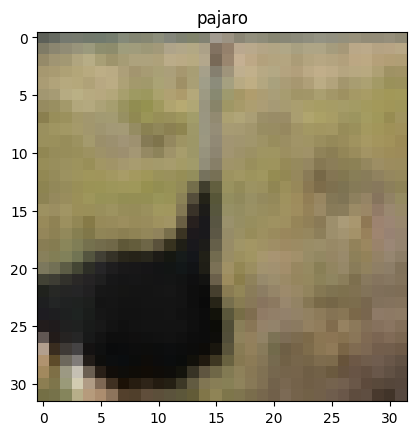

In [129]:
idx = 121

plt.imshow(x_train[idx])
plt.title(label_decoding[y_train[idx][0]])
plt.show()

In [130]:
print(x_train[idx].min())
print(x_train[idx].max())

6
210


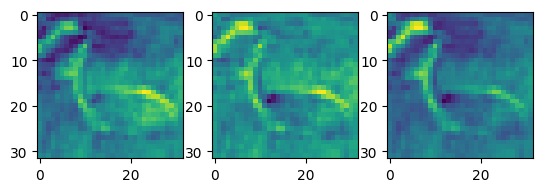

In [131]:
idx = 130

plt.subplot(1, 3, 1)
plt.imshow(x_train[idx][:, :, 0])
plt.subplot(1, 3, 2)
plt.imshow(x_train[idx][:, :, 1])
plt.subplot(1, 3, 3)
plt.imshow(x_train[idx][:, :, 2])
plt.show()

In [13]:
x_train, x_test = x_train / 255.0, x_test / 255.0 #normalizamos

In [14]:
x_train.shape

(50000, 32, 32, 3)

In [80]:
#x_train = x_train.reshape(x_train.shape[0],-1) #pasamos a 1dimension
#x_test = x_test.reshape(x_test.shape[0],-1)

In [15]:
x_train.shape

(50000, 32, 32, 3)

ValueError: x and y can be no greater than 2D, but have shapes (32,) and (32, 32, 3)

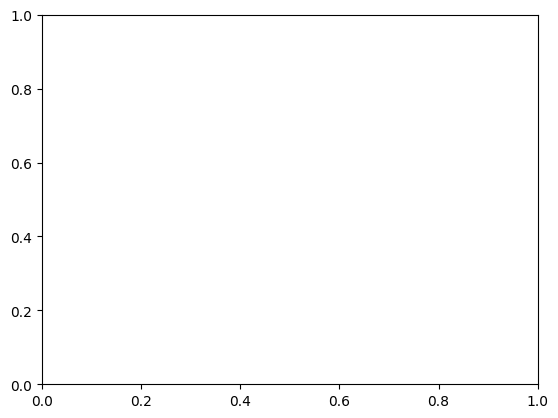

In [112]:
plt.plot(x_train[120])
plt.show()

In [36]:
#y_train = tf.cast(y_train, tf.int32) #cambio a tipo de dato que necesito para el one-hot
#y_test = tf.cast(y_test, tf.int32)

In [16]:
y_train = tf.one_hot(y_train, depth=10) #codifico las etiquetas
y_test = tf.one_hot(y_test, depth=10)

In [17]:
y_train[0]

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)>

In [18]:
lr = 0.01
n_epoch = 10
batch_size = 128

In [19]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation="relu"),
    # Dense(256, activation="relu"),
    # Dense(256, activation="relu"),
    Dense(10, activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,269,002 (73.51 MB)

 Trainable params: 19,269,002 (73.51 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
optimizer = SGD(learning_rate=lr)

In [22]:
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [23]:
y_test[:, 0, :].shape

TensorShape([10000, 10])

In [24]:
y_train.shape

TensorShape([50000, 1, 10])

In [25]:
x_train.shape

(50000, 32, 32, 3)

In [26]:
H = model.fit(
    x_train, y_train[:, 0, :],
    validation_data=(x_test, y_test[:, 0, :]),
    epochs=n_epoch,
    batch_size=batch_size
)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 150528, but received input with shape (None, 3072)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 32, 32, 3), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [ ]:
model.save("toy_cifar10_keras.keras")

In [ ]:
model2 = tf.keras.models.load_model("toy_cifar10_keras.keras")

In [ ]:
model2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,772 (397.55 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
y = model.predict(x_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


In [ ]:
print([label_decoding[l] for l in np.argmax(y, axis=1)])

['gato', 'gato', 'perro', 'gato', 'gato', 'perro', 'perro', 'perro', 'perro', 'perro']




## 2 Teoría de optimización: Gradient Descent, Stochastic Gradient Descent, Mini-batch Gradient Descent

Ayer estuvimos viendo cómo funciona el gradient descent, os acordáis, ¿verdad? En la clase de hoy, vamos a ver diferentes formas de utilizar el gradient descent para ganar velocidad.

Para ello, vamos a recordar brevemente como funciona el descenso de gradiente:  1) Calculo del error de todas las muestras del set de training 2) actualizar los pesos en la dirección que indica el gradiente respecto a cada uno de ellos. Por tanto, necesitamos, **para cada época, calcular todas las predicciones (etapa forward), luego los errores, y luego propagar los errores hacia atrás para ver cuánto influye cada peso en ese error y actualizarlo en consecuencia.**

Imaginaos que:

* tenemos un dataset de **100.000 muestras**
* que cada etapa forward tarda **2ms**
* cada cálculo del error **1ms**
* cada etapa de backpropagation tarda **3ms**

Si hacemos el cálculo, tenemos que:

**Tiempo por época** $= (2ms+1ms+3ms)·100.000$ muestras $= 600.000ms = 600$ segundos $=$ **10 minutos**

De normal, una red puede requerir cientos, si no miles de épocas, para conseguir una convergencia adecuada. Pongamos que necesitamos 100 épocas, que es un número bajo. ¿Cuánto tardaría en total en entrenarse la red?

**Tiempo total de entrenamiento** $=10$ minutos $· 100$ épocas $= 1.000$ minutos $=$ **16'6 horas !!!**

No parece muy cómodo tener que esperar más de 16 horas para ver los resultados de una red, ¿verdad? Y hemos sido cautos suponiendo que teníamos solo 100.000 muestras. Como ya hemos visto anteriormente, ImageNet, por ejemplo, consta de 1.2 millones de imágenes, lo que nos costaría 2h por época, o lo que es lo mismo, 8.3 días, **más de una semana para ver el comportamiento de una red.** ¿Se os ocurre alguna forma de disminuir este tiempo?

Una forma de reducir drásticamente el tiempo necesario sería utilizar una sola muestra escogida aleatoriamente cada vez que quisieramos actualizar los pesos. De esta forma, para actualizar los pesos simplemente tendríamos que calcular las predicciones, errores y backpropagation de una muestra. Esto reduciría nuestro tiempo total a:

**Tiempo total de entrenamiento** $=(2ms+1ms+3ms)·1$ muestra $·100$ épocas $= 600ms = $ **0,6s**

### ¡Qué maravilla! ¡Acabamos de arreglar el mundo!

A este método se le conoce como **Stochastic Gradient Descent**, y estoy seguro de que todos vosotros os habéis dado cuenta de que tiene una **desventaja MUY IMPORTANTE**. ¿Quién me la dice?

Os voy a dar una pista:

### ¿Cuál creéis que es el camino seguido por el Gradient Descent, y cuál el seguido por el Stochastic Gradient Descent?
<img src="https://image.ibb.co/hiK2BT/mountain_gd_sgd_mbsgd_hidden.png" alt="mountain_gd_sgd_mbsgd_hidden" border="0">
<!--
<img src="https://image.ibb.co/n2RFWT/mountain_gd_sgd_mbsgd.png" alt="mountain_gd_sgd_mbsgd" border="0">
<!-- <img src="https://image.ibb.co/jZHNBT/contours_gd_sgd_mbsgd.png" alt="contours_gd_sgd_mbsgd" border="0"> -->

El camino rojo es el que sigue el gradient descent, que al calcular el gradiente usando todas las muestras del dataset consigue unas actualizaciones coherentes siempre en la dirección que permite minimizar el error.

Y si! El camino magenta es el seguido por el SGD. ¿Qué es lo que está pasando? Cada actualización de los pesos se hace para minimizar el error teniendo en cuenta solo una muestra, así que lo que minimizamos es el error para esa muestra en particular. Por eso, tiene un comportamiento más caótico y le cuesta más converger, aunque, a cambio, se ejecuta mucho más rápido, por lo que en el tiempo que el GD necesita para ejecutar una época, el SGD puede ejecutar miles.

**Como siempre, la virtud se encuentra en el término medio. ¿Véis la linea verde, verdad? ¡Esa es la buena! ¿Cómo llegamos a ella?**

Bueno, vamos a pensar qué tenemos hasta ahora. Tenemos:

* Un método que calcula las predicciones y errores de **todos** los elementos de nuestro training set: **(Vanilla) Gradient Descent**
* Un método que calcula las predicciones y errores de **1 elemento** escogido aleatoriamente de nuestro training set: **Stochastic Gradient Descent**

¿Qué os parecería que en vez de **1 solo elemento**, escogiésemos **N elementos**? De esta forma:

* Aumentamos la **estabilidad** del algoritmo, ya que no solo nos fijamos en un solo elemento, sino en $k$ (es decir, disminuímos los cambios de dirección tan abruptos y caóticos que tiene la línea magenta).
* Disminuimos el **tiempo de ejecución** con respecto al gradient descent tradicional, pues pasamos de las $N$ muestras que tiene nuestro training set, a $k$, donde $k << N$.

Parece una alternativa interesante, ¿no creéis? Este método se conoce como **Mini-batch Stochastic Gradient Descent**, y es realmente el que se utiliza en la práctica.

Normalmente, $k$ se elige para que sea una potencia de 2, ya que eso permite aprovechar algunas optimizaciones que tienen las GPUs implementadas para estos casos. Un $k$ típico podría ser $k=32$, pero al final esto lo limita la memoria de la GPU.

Cuanto más bajo sea $k$, más se parecerá al SGD puro, y más épocas le costará converger, aunque también es verdad que las calculará más rápido.

Y a la inversa, cuanto más alto sea $k$, más se parecerá al GD puro, y más le costará calcular cada época, pero necesitará menos para converger.

### Pues con esto ya lo sabéis todo sobre el Gradient Descent y los diferentes tipos de implementaciones!

Vamos a ver ahora qué es el learning rate y el batch size, y cómo influyen.









## 3 Optimización de hiperparámetros

De entre todos los hiperparámetros, el learning rate y el batch size son dos parámetros directamente relacionados con el algoritmo del gradient descent. A continuación, vamos a explicar todos los hiperparámetros que influyen en el entrenamiento de una red neuronal y cómo afectan.

### 3.1 Learning rate

Como ya sabéis de la anterior sesión, la forma de actualizar los pesos es mediante estas fórmulas:

<center><img src="https://image.ibb.co/jMmHRT/net_weights_update.png" alt="net_weights_update" border="0" height="250"></center>

¿Os acordáis, verdad? Lo que multiplica al $\frac{\partial E_{total}}{\partial w_n}$, llamado $\eta$, es el **learning rate**, que es lo que indica **la importancia** que le damos al error para actualizar cada peso, es decir, la **rapidez** o cómo de abruptos son los cambios en los pesos.

Así, un $\eta$ muy alto, hará que los cambios en los pesos sean muy grandes de una iteración a otra, lo que tiene el problema de que podemos llegar a saltarnos nuestro mínimo.

Fijaos, con esta imagen se ve estupendamente:

<img src="https://image.ibb.co/ncnAY8/learning_rate_eta.png" alt="learning_rate_eta" border="0" height="150">

Otra posibilidad es establecer un $\eta$ muy bajo, lo que haría que nuestra red necesitara muchísimas épocas para llegar a un mínimo aceptable. Además, correríamos el riesgo de quedarnos atrapados en un mínimo peor del mejor que podríamos conseguir con un $\eta$ más alto.

<img src="https://image.ibb.co/frt3Lo/learning_rate_eta_low.gif" alt="learning_rate_eta_low" border="0" height="200">

Vamos a hacer un pequeño inciso para hablar sobre los mínimos: lo que conseguimos con una **red neuronal**, normalmente, no es alcanzar el mínimo global de nuestra función, sino que **alcanzamos un mínimo local lo suficientemente bueno como para realizar correctamente la tarea que estamos desarrollando**.

Tras haber aclarado esto, queda patente lo importante que es conseguir un learning rate adecuado, ¿verdad? Y, ¿cómo lo hacemos? Primero, ¿qué es lo que buscamos? Fijaos en esta imagen:

<img src="https://image.ibb.co/heYQY8/learning_rate_eta_graph.png" alt="learning_rate_eta_graph" border="0" height="250">

Lo que queremos es un *learning rate* óptimo, que nos permita ir reduciendo el error conforme van pasando las épocas, hasta llegar a nuestro mínimo buscado. En la gráfica, este *learning rate* sería la línea roja. ¿Y cómo conseguimos que nuestro learning rate sea el óptimo?

Pues una opción muy utilizada es aplicar un **decrecimiento** o *decay* a nuestro learning rate **conforme más va disminuyendo la función de pérdidas** (lo que indica que estamos llegando al mínimo buscado).

<img src="https://image.ibb.co/mdBUt8/learning_rate_eta_decreasing.png" alt="learning_rate_eta_decreasing" border="0" height="250">

De esta forma, evitamos morirnos de viejos esperando a que converja por haber elegido un learning rate muy bajito, y evitamos saltarnos nuestro mínimo porque cuanto más cerca estamos de él más pequeños son los pasos que damos hacia él.

Vamos a ver cómo se comportaría la última red que implementamos (la que trabajaba con el MNIST) con **diferentes learning rates**.

Además vamos a aprovechar este ejercicio para convertir nuestro código dejado caer en un script a una función cuya cabecera será la siguiente:

def train_network(learning_rate, batch_size, n_epochs)

In [13]:
# Ejemplos learning rate

# En primer lugar, hacemos los imports necesarios y después definimos una
# función que creará y entrenará la red
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Importamos el dataset MNIST desde Keras datasets y cargamos los datos #(X)
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_te, y_te) = mnist.load_data()
# Normalizamos los datos en el rango de 0-1 para que computacionalmente sea más eficiente el proceso #(X)
x_train, x_te = x_train / 255.0, x_te / 255.0
# Pasamos a etiquetas one-hot encoded #(X)
y_train = to_categorical(y_train)
y_te = to_categorical(y_te)
# Dividimos el conjunto de training en training y validation #(X)
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [14]:
# Definimos la función para entrenar nuestra red con los parámetros deseados
def train_network(learning_rate, batch_size, num_epochs):

  # Implementamos la red empleando Keras
  model = Sequential() # Instancia de modelo API secuencial #(X)
  model.add(Flatten()) # Estiramos los datos en forma de vector como entrada a nuestro Perceptrón Simple #(X)
  model.add(Dense(10, input_shape=(784,), activation="softmax")) # Construimos nuestro Perceptrón simple con una única capa Dense #(X)
  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  model.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate), metrics=["accuracy"])  #(X)

  # Entrenando la solución
  H = model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=num_epochs, batch_size=batch_size)  #(X)

  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x_te, batch_size=batch_size)  #(X)
  print(classification_report(y_te.argmax(axis=1), predictions.argmax(axis=1)))

  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

Los valores típicos de learning rate suelen ser:

* 0.1
* 0.01
* 0.001

A partir de ahí, nos toca a nosotros *tunear* el learning rate según lo que veamos que ocurre.

[INFO]: Entrenando red neuronal...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7689 - loss: 7.1805 - val_accuracy: 0.8073 - val_loss: 4.6463
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8651 - loss: 2.1065 - val_accuracy: 0.8370 - val_loss: 2.2501
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8813 - loss: 1.7046 - val_accuracy: 0.8607 - val_loss: 1.9006
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8819 - loss: 1.7877 - val_accuracy: 0.9067 - val_loss: 1.2291
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8809 - loss: 1.7145 - val_accuracy: 0.9013 - val_loss: 1.2952
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8763 - loss: 1.8224 - val_accuracy: 0.9012 - val_loss: 1.3345
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8851 - loss: 1.6061 - val_accuracy: 0.8962 - val_loss: 1.3658
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.883

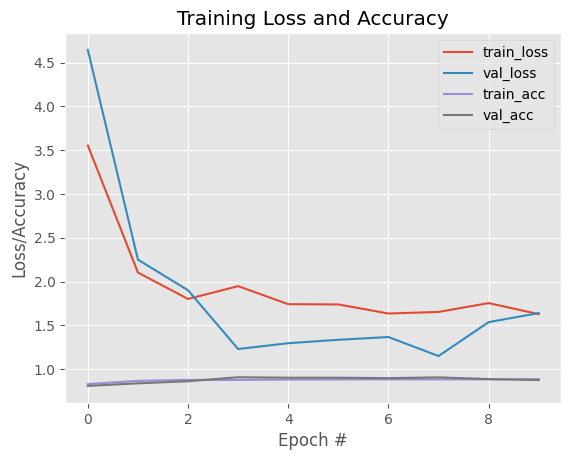

In [15]:
# vamos a probar con un learning rate ENORME
learning_rate = 10.0
n_epochs = 10
batch_size = 128
train_network(learning_rate, batch_size, n_epochs)

En este caso, incluso escogiendo un learning rate que debería hacerlo explotar todo, la red puede llegar a converger. Esto se debe a que es un problema muy sencillo, pero no pasaría igual si estuvieramos trabajando con otro problema más real, como comprobaréis en la próxima sesión.

Pero como os digo, está al limite: si lo reejecutáis, os dará valores distintos, siendo lo más normal que no logre converger (aparecería `nan` como salida). Esta variabilidad se debe a que el cargador de datos aleatoriza las imágenes en cada ejecución, y el orden en que la red ve las imágenes le hace converger o no.

Veamos qué ocurre cuando disminuímos el learning rate:

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO]: Entrenando red neuronal...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7706 - loss: 0.8899 - val_accuracy: 0.8912 - val_loss: 0.4074
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8918 - loss: 0.3965 - val_accuracy: 0.9040 - val_loss: 0.3561
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9031 - loss: 0.3525 - val_accuracy: 0.9067 - val_loss: 0.3341
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9085 - loss: 0.3310 - val_accuracy: 0.9090 - val_loss: 0.3218
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9111 - loss: 0.3209 - val_accuracy: 0.9118 - val_loss: 0.3149
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9143 - loss: 0.3107 - val_accuracy: 0.9135 - val_loss: 0.3069
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9125 - loss: 0.3097 - val_accuracy: 0.9163 - val_loss: 0.3017
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.914

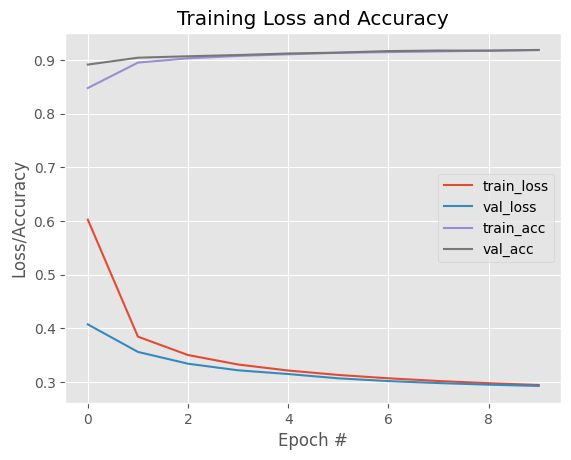

In [16]:
# vamos a probar con 0.1
learning_rate = 0.1
n_epochs = 10
batch_size = 128
train_network(learning_rate, batch_size, n_epochs)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO]: Entrenando red neuronal...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5144 - loss: 1.7233 - val_accuracy: 0.8172 - val_loss: 0.8797
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8310 - loss: 0.8005 - val_accuracy: 0.8492 - val_loss: 0.6612
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8512 - loss: 0.6365 - val_accuracy: 0.8622 - val_loss: 0.5723
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8642 - loss: 0.5566 - val_accuracy: 0.8675 - val_loss: 0.5222
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8720 - loss: 0.5090 - val_accuracy: 0.8750 - val_loss: 0.4894
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8752 - loss: 0.4818 - val_accuracy: 0.8787 - val_loss: 0.4655
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8821 - loss: 0.4570 - val_accuracy: 0.8810 - val_loss: 0.4474
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.884

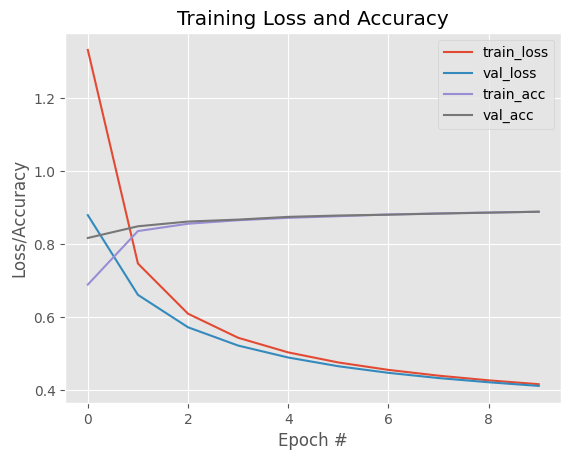

In [17]:
# y ahora con uno muy pequeño
learning_rate = 0.01
n_epochs = 10
batch_size = 128
train_network(learning_rate, batch_size, n_epochs)

Como podéis comprobar, en este caso las pérdidas van disminuyendo paulatinamente, pero tan despacio, que podría llevarnos horas conseguir la solución que hemos alcanzado con un learning rate adecuado en solo 10 épocas.


Bueno, pues la mejor ejecución la hemos conseguido con learning rate = 0.1. Pero... ¿se puede mejorar?

Como podréis imaginaros, el learning rate es un parámetro muy importante. Ya hemos visto antes que si ponemos un learning rate muy alto, podemos saltarnos el mínimo. En cambio, si ponemos un learning rate muy bajo, igual nos morimos de viejos antes de ver el resultado. ¿Cómo podemos arreglar esto? Pues una forma sería dar pasos más grandes al principio, y conforme nos aproximamos a la meta, empezar a disminuir su longitud para no pasárnosla, ¿no os parece?

Pues esto mismo se llama learning rate *decay*. A continuación vamos a implementar el standard "decay" de keras. De esa forma, se esablece que nuestro decaimiento  sea la tasa de aprendizaje dividida por el número total de épocas para las que estamos entrenando la red (una regla general común).

Internamente, Keras aplica el siguiente programa de tasa de aprendizaje para ajustar la tasa de aprendizaje después de cada actualización por lotes.

La actualizació sigue la siguiente fórmula:

lr = init_lr * 1 / (1 + decay * iteraciones)

¿Qué os parece si lo implementamos en nuestro ejemplo?

Vamos allá!

In [19]:
# definimos la función para entrenar nuestra red con los parámetros deseados
def train_network_decay(learning_rate, lr_decay, batch_size, num_epochs):

  # Implementamos la red empleando Keras
  model = Sequential() # Instancia de modelo API secuencial #(X)
  model.add(Flatten()) # Estiramos los datos en forma de vector como entrada a nuestro Perceptrón Simple #(X)
  model.add(Dense(10, input_shape=(784,), activation="softmax")) # Construimos nuestro Perceptrón simple con una única capa Dense #(X)
  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      learning_rate,
      decay_steps=100000, # Un valor por defecto, ajusta si es necesario
      decay_rate=lr_decay,
      staircase=True)
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

  # Entrenando la solución
  H = model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=num_epochs, batch_size=batch_size)

  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x_te, batch_size=batch_size)
  print(classification_report(y_te.argmax(axis=1), predictions.argmax(axis=1)))

  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

In [ ]:
# vamos a probar nuestra red con decay
learning_rate = 0.2
lr_decay =  ##code
num_epochs = 10
batch_size = 128
## Code ##

Fijaos que con esta simple mejora, hemos sido capaces de mejorar, o al menos igualar, la precisión un poco con respecto al learning rate óptimo, que habíamos definido como 0.1. Y existen métodos más complejos de aplicar el *decay* que producen mejores resultados. (https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules)

**Así que ya sabéis, ¡¡mucha atención al learning rate!!**

**IMPORTANTE**: Cabe decir que esta implementación de learning rate *decay* es muy básico. En realidad existen distintos tipos de "calendarios" de actualización de learning rate: de escalón, polinomial, etc. Al final, lo que hacen todos es modificar el learning rate de acuerdo a una ecuación o regla.


### 3.2 Batch size

Vamos a ver ahora qué es el **batch size**. ¿Recordáis cuando hemos hablado antes del SGD y el Mini-batch SGD?

Recordad que el SGD es un Mini-bacth SGD donde $k=1$.

Y que en el Mini-bacth SGD, la $k$ indica el número de muestras que se utilizan para actualizar los pesos cada vez. Realmente, este no es un parámetro crítico y se suele establecer como el **número máximo de muestras potencia de 2 que caben en nuestra GPU**.

Ejemplos:

* Tenemos una GPU con 8GB de memoria, cuantas muestras nos caben si cada imagen ocupa 1MB?

Bueno, ¡pues no es tan fácil! Resulta que depende de la arquitectura de la red. Las capas *Densas* o *Fully Connected*, que son las tradicionales en las que todas las neuronas se interconectan con todas las neuronas de la siguiente capa, son las que **más parametros tienen**, y por consiguiente, las que **más memoria ocupan**.

Luego tambien tenemos capas convolucionales, de pooling, de dropout, y de muchos otros tipos. Así que en la práctica, es difícil calcular a mano cual es el número máximo de muestras que podemos usar.

Lo que se hace es probar con tamaños de batch potencia de 2 e ir disminuyéndolo si tenemos un error de memoria. Por ejemplo, podríamos empezar con 512, y si nos da error ir bajando a 256, 128, 64, 32, 16, 8, 4, 2 e incluso 1. Dependiendo de la arquitectura de nuestra red, puede llegar a pasarnos que tengamos que usar $k=1$, y por tanto, SGD.

Aunque muchas veces es preferible disminuir el tamaño de la imagen, por ejemplo, de 512x512 a 256x256 o 128x128 pixels, y usar un $k$ mayor.

Yo por ejemplo he tenido que usar $k=1$ con imágenes de 512x512 y la arquitectura DenseNet. **Y no hay problema**, simplemente tarda **más tiempo** en llegar a una solución adecuada.

Vamos a ver algunos casos de diferentes bath size siguiendo con el ejemplo anterior:

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO]: Entrenando red neuronal...
Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5554 - loss: 1.4913 - val_accuracy: 0.8783 - val_loss: 0.4391
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8817 - loss: 0.4265 - val_accuracy: 0.8902 - val_loss: 0.3876
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8937 - loss: 0.3791 - val_accuracy: 0.9010 - val_loss: 0.3668
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8983 - loss: 0.3641 - val_accuracy: 0.9072 - val_loss: 0.3407
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9024 - loss: 0.3456 - val_accuracy: 0.9092 - val_loss: 0.3311
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9099 - loss: 0.3252 - val_accuracy: 0.9062 - val_loss: 0.3260
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9090 - loss: 0.3295 - val_accuracy: 0.9120 - val_loss: 0.3172
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9130 - loss

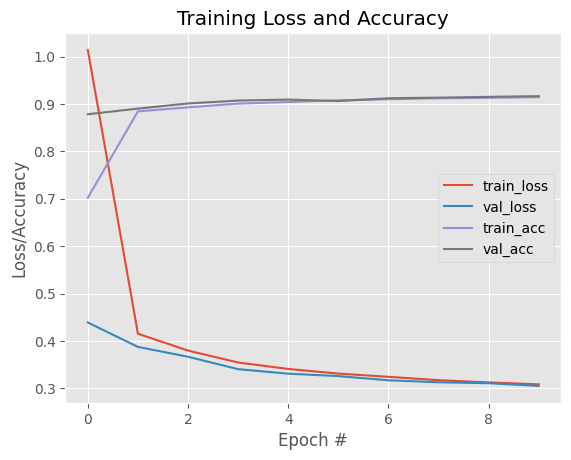

In [21]:
# con batch_size = 2048
learning_rate = 1.
lr_decay = 1e-3
n_epochs = 10
batch_size = 2048
train_network_decay(learning_rate, lr_decay, batch_size, n_epochs)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO]: Entrenando red neuronal...
Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7732 - loss: 0.8384 - val_accuracy: 0.9092 - val_loss: 0.3223
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9086 - loss: 0.3215 - val_accuracy: 0.9157 - val_loss: 0.2949
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9143 - loss: 0.3033 - val_accuracy: 0.9165 - val_loss: 0.2948
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9193 - loss: 0.2875 - val_accuracy: 0.9197 - val_loss: 0.2831
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9193 - loss: 0.2840 - val_accuracy: 0.8922 - val_loss: 0.3461
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9193 - loss: 0.2888 - val_accuracy: 0.9252 - val_loss: 0.2809
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9226 - loss: 0.2724 - val_accuracy: 0.9230 - val_loss: 0.2797
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.922

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.95      0.99      0.97      1135
           2       0.90      0.93      0.91      1032
           3       0.90      0.90      0.90      1010
           4       0.91      0.95      0.93       982
           5       0.85      0.88      0.86       892
           6       0.91      0.96      0.93       958
           7       0.93      0.92      0.93      1028
           8       0.95      0.76      0.85       974
           9       0.91      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.92      0.92     10000



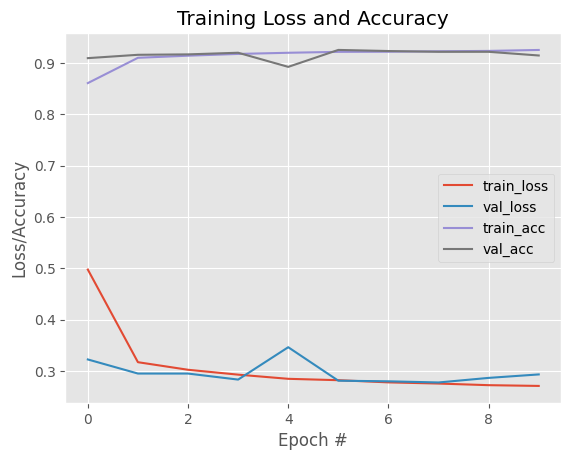

In [22]:
# con batch_size = 256
learning_rate = 1.
lr_decay = 1e-3
n_epochs = 10
batch_size = 256
train_network_decay(learning_rate, lr_decay, batch_size, n_epochs)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO]: Entrenando red neuronal...
Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8389 - loss: 0.6568 - val_accuracy: 0.8892 - val_loss: 0.4373
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8933 - loss: 0.4138 - val_accuracy: 0.8823 - val_loss: 0.4368
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8998 - loss: 0.3919 - val_accuracy: 0.9160 - val_loss: 0.3340
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9005 - loss: 0.3923 - val_accuracy: 0.9073 - val_loss: 0.3785
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9033 - loss: 0.3827 - val_accuracy: 0.8725 - val_loss: 0.4957
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9048 - loss: 0.3721 - val_accuracy: 0.8687 - val_loss: 0.5078
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9068 - loss: 0.3670 - val_accuracy: 0.8988 - val_loss: 0.3914
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step 

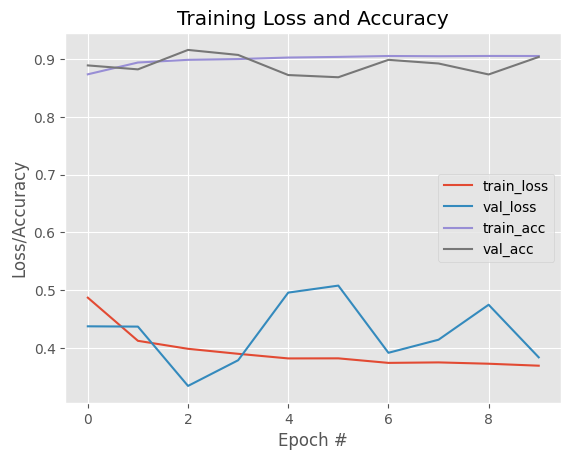

In [23]:
# con batch_size = 32
learning_rate = 1.
lr_decay = 1e-3
n_epochs = 10
batch_size = 32
train_network_decay(learning_rate, lr_decay, batch_size, n_epochs)

In [ ]:
# recordad la montaña, estamos saltando de arriba a abajo y de abajo a arriba, en vez de ir siempre hacia abajo...

### Vaya!! Qué es lo que ha pasado?

Es muy importante tener en cuenta que el **learning rate va relacionado con el batch size**.

Si nos aproximamos a $k=1$, debemos bajar el learning rate para que las actualizaciones de los pesos tengan menos importancia, ya que cada vez se aproxima más al SGD, es decir, a cálculos del gradiente con muestras aleatorias.

Veamos qué pasa si disminuimos el learning rate:

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO]: Entrenando red neuronal...
Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8418 - loss: 0.5918 - val_accuracy: 0.9087 - val_loss: 0.3249
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9089 - loss: 0.3274 - val_accuracy: 0.9142 - val_loss: 0.3059
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9162 - loss: 0.3032 - val_accuracy: 0.9175 - val_loss: 0.2958
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9190 - loss: 0.2911 - val_accuracy: 0.9218 - val_loss: 0.2838
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9197 - loss: 0.2872 - val_accuracy: 0.9197 - val_loss: 0.2827
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9209 - loss: 0.2842 - val_accuracy: 0.9212 - val_loss: 0.2817
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9233 - loss: 0.2696 - val_accuracy: 0.9240 - val_loss: 0.2795
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step 

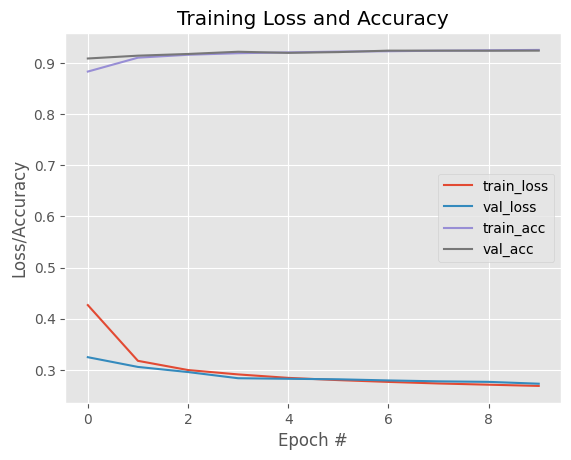

In [24]:
# con batch_size = 32 y learning rate = 0.1
learning_rate = 0.1
lr_decay = 1e-3
n_epochs = 10
batch_size = 32
train_network_decay(learning_rate, lr_decay, batch_size, n_epochs)

Y si os fijáis en la curva de pérdidas, podéis intuir que todavía es demasiado grande, puesto que la función no es monótona decreciente, es decir, que no disminuye en cada época. Así que sería mejor usar un learning rate aun menor. Veámoslo:

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO]: Entrenando red neuronal...
Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7048 - loss: 1.1507 - val_accuracy: 0.8682 - val_loss: 0.5187
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8728 - loss: 0.4887 - val_accuracy: 0.8858 - val_loss: 0.4307
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8905 - loss: 0.4164 - val_accuracy: 0.8937 - val_loss: 0.3926
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8915 - loss: 0.3937 - val_accuracy: 0.8978 - val_loss: 0.3701
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8973 - loss: 0.3709 - val_accuracy: 0.9027 - val_loss: 0.3555
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9002 - loss: 0.3570 - val_accuracy: 0.9050 - val_loss: 0.3447
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9047 - loss: 0.3407 - val_accuracy: 0.9073 - val_loss: 0.3371
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step 

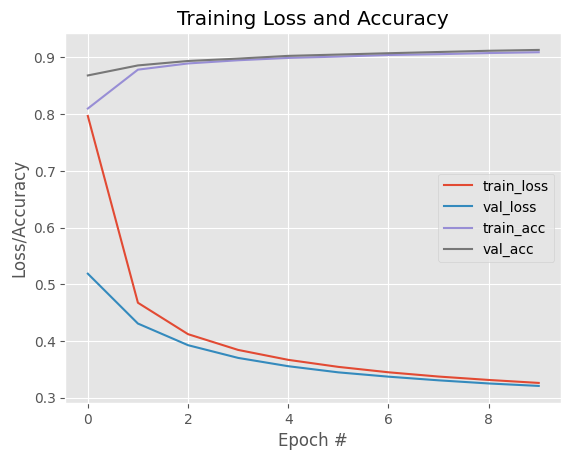

In [25]:
# con batch_size = 32 y learning_rate=0.01
learning_rate = 0.01
lr_decay = 1e-3
n_epochs = 10
batch_size = 32
train_network_decay(learning_rate, lr_decay, batch_size, n_epochs)

Fijáos como el Accuracy es menor con el learning rate más bajo. ¿Esto por qué? Acordaos! Necesitamos más épocas, ya que los pesos se actualizan más lentamente :)

### ¿Os dáis cuenta? Como deberes os dejo que hagáis pruebas variando estos parámetros ;-)

### 3.3 Funciones de pérdidas


¿Qué es una función de pérdidas (o de coste)? ¿Quién sabe decírmelo?

La función de pérdidas es la que nos indica en cuánto nos hemos equivocado con nuestras predicciones.

Imaginad que tenemos que adivinar cuánto cuesta una casa simplemente viendo una foto. Nuestra red tendría como entrada los píxels de la foto, y como salida un número indicando el precio.

Por ejemplo, digamos que queremos predecir el precio de una casa. Imaginaos que estamos entrenando la red y que dicha casa está dentro de nuestro conjunto de training. Cuando la imagen pasa hacia delante, se calcula una predicción, que es que vale 323.567€. La verdad es que la casa cuesta 600.000€, así que parece obvio que una función de pérdidas adecuada podría ser:

$f_{loss} = prediccion - valor\_real$

¿Lo entendéis verdad? Es exactamente lo mismo que con un SVM o la regresión lineal, por ejemplo.

Las funciones de pérdidas más comunes son:

* **Problemas de regresión**
 * Mean Squared Error
 * Mean Absolute Error
* **Problemas de clasificación**
 * Binary Cross-Entropy
 * Categorical Cross-Entropy

Veamos qué son cada una:

* Mean Squared Error

$$MSE = \frac{1}{n} \sum^{n}_{i=1} (y_i-x_i)^2$$

* Mean Absolute Error

$$MAE = \frac{1}{n} \sum^{n}_{i=1} |y_i-x_i|$$

Hasta aquí todo bien verdad? Pero.. ¿qué es la entropía cruzada o cross-entropy?

Vamos a verla en este ejemplo a parte:

https://colab.research.google.com/drive/1FLM26U7Co5DwqCpyVyxFgQJfax94cEnE?authuser=2

Bueno, pues ahora que está claro qué son las funciones de pérdidas, vamos a por las de activación!

### 3.4 Funciones de activación

Os he de confesar una cosa: la magia de las redes neuronales no es solo el back-propagation. Sin las funciones de activación, las redes neuronales no funcionarían. ¿Alguien sabe decirme por qué?



Os doy una pista:

### ¿Qué pasaría si no existiese la función de activación?

<img src="https://image.ibb.co/ftYCVo/what_if_no_activation_function.png" alt="what_if_no_activation_function" border="0">

Tendríamos que $y(x)= Wx + b$. Esto es una combinación lineal que sería incapaz incluso de resolver un problema como el XOR.

<img src="https://image.ibb.co/kg9GO8/xor.gif" alt="xor" border="0">

Por lo tanto, necesitamos una forma de introducir **no linealidades**, y de eso es de lo que se encarga la **función de activación**. En la siguiente imagen podéis ver algunas de las más típicas, y donde interviene en la red:

<img src="https://image.ibb.co/bVS6qo/perceptron_activation.png" alt="perceptron_activation" border="0" width="600">

Aquí podéis ver las más usadas:

<img src="https://image.ibb.co/gMG5kd/activation_functions.png" alt="activation_functions" border="0" width="600">

Es difícil saber con cuál de ellas nuestra red se va a comportar mejor, pero existe una que suele dar buenos resultados casi siempre: la **ReLU**.

Por lo tanto, siempre que empecemos, emplearemos la ReLU, y una vez consigamos unos resultados que consideremos buenos, podemos probar con la **Leaky ReLU**, o cualquier otra que os apetezca. Cada día salen nuevas, y una simple búsqueda en google os puede llevar a alguna interesante: como la SELU, por ejemplo (https://towardsdatascience.com/selu-make-fnns-great-again-snn-8d61526802a9).

Muchas de estas funciones de activación necesitan métodos específicos de **inicialización de pesos**, para que esten dentro de unos valores y que el descenso del gradiente funcione adecuadamente.

A continuación, vamos a darle profundiad a la red y veamos qué es lo que pasa si empleamos diferentes funciones de activación con nuestra ya conocida red:

In [16]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense

# Importamos el dataset MNIST desde Keras datasets y cargamos los datos #(X)
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_te, y_te) = mnist.load_data()
# Normalizamos los datos en el rango de 0-1 para que computacionalmente sea más eficiente el proceso #(X)
x_train, x_te = x_train / 255.0, x_te / 255.0
# Pasamos a etiquetas one-hot encoded #(X)
y_train = to_categorical(y_train)
y_te = to_categorical(y_te)
# Dividimos el conjunto de training en training y validation #(X)
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [19]:
# definimos la función para entrenar nuestra red con los parámetros deseados
def train_network_decay_fnact(activation_function, learning_rate, lr_decay, batch_size, num_epochs):

  # Implementamos la red empleando Keras
  model = Sequential() # Instancia de modelo API secuencial #(X)
  model.add(Flatten()) # Estiramos los datos en forma de vector como entrada a nuestro Perceptrón Simple #(X)
  model.add(Dense(32, input_shape=(784,), activation=activation_function)) ## Code ### Añadimos una capa con 32 neuronas y añadimos una función de activacion
  model.add(Dense(10, input_shape=(784,), activation="softmax")) # Construimos nuestro Perceptrón simple con una única capa Dense #(X)
  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  opt = SGD(learning_rate=learning_rate)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])  #(X)

  # Entrenando la solución
  H = model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=num_epochs, batch_size=batch_size)  #(X)

  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x_te, batch_size=batch_size)  #(X)
  print(classification_report(y_te.argmax(axis=1), predictions.argmax(axis=1)))

  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

# Veamos con la ReLU

<img src="https://image.ibb.co/mSsKBT/act_fn_relu.png" alt="act_fn_relu" border="0" height="250">

<img src="https://image.ibb.co/iUdsWT/act_fn_relu2.png" alt="act_fn_relu2" border="0" height="250">

<img src="https://image.ibb.co/fzXako/act_fn_relu3.png" alt="act_fn_relu3" border="0" height="250">

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO]: Entrenando red neuronal...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7573 - loss: 0.8656 - val_accuracy: 0.9115 - val_loss: 0.3233
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9132 - loss: 0.3066 - val_accuracy: 0.9258 - val_loss: 0.2654
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9297 - loss: 0.2504 - val_accuracy: 0.9358 - val_loss: 0.2311
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9354 - loss: 0.2270 - val_accuracy: 0.9405 - val_loss: 0.2051
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9430 - loss: 0.2004 - val_accuracy: 0.9452 - val_loss: 0.1908
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9489 - loss: 0.1810 - val_accuracy: 0.9490 - val_loss: 0.1843
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9532 - loss: 0.1679 - val_accuracy: 0.9522 - val_loss: 0.1706
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.955

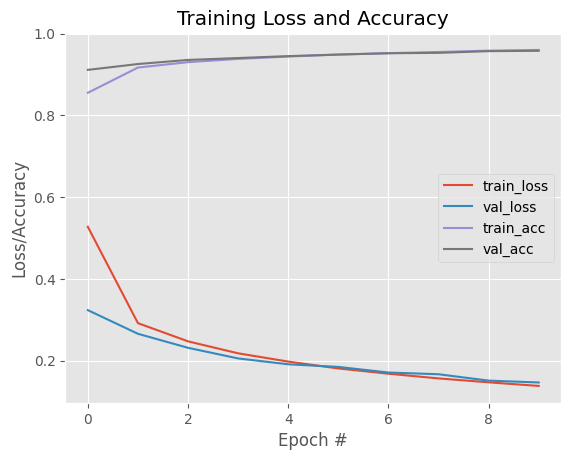

In [20]:
activation_function = "relu"
learning_rate = 0.1
lr_decay = 1e-3
num_epochs = 10
batch_size = 128
train_network_decay_fnact(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

# Veamos con la Leaky RELU

<img src="https://image.ibb.co/j5pAJ8/act_fn_lrelu.png" alt="act_fn_lrelu" border="0" height="250">

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO]: Entrenando red neuronal...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7628 - loss: 0.8353 - val_accuracy: 0.9002 - val_loss: 0.3362
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9088 - loss: 0.3171 - val_accuracy: 0.9198 - val_loss: 0.2759
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9197 - loss: 0.2791 - val_accuracy: 0.9240 - val_loss: 0.2569
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9283 - loss: 0.2525 - val_accuracy: 0.9343 - val_loss: 0.2291
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9345 - loss: 0.2301 - val_accuracy: 0.9390 - val_loss: 0.2146
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9419 - loss: 0.2080 - val_accuracy: 0.9415 - val_loss: 0.2059
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9439 - loss: 0.1951 - val_accuracy: 0.9460 - val_loss: 0.1898
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.948

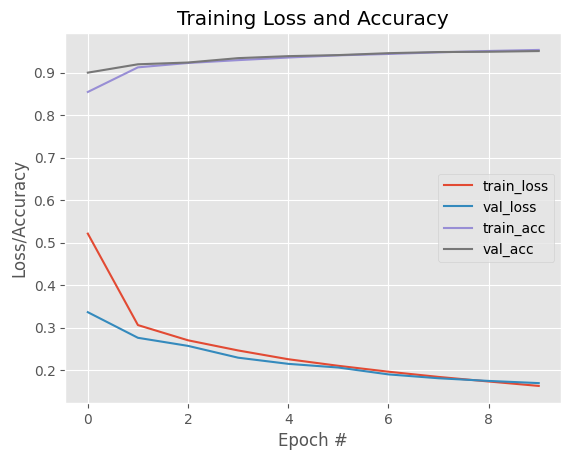

In [21]:
activation_function = "leaky_relu"
learning_rate = 0.1
lr_decay = 1e-3
num_epochs = 10
batch_size = 128
train_network_decay_fnact(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

# Veamos con la ELU

<img src="https://image.ibb.co/gEJgQo/act_fn_elu.png" alt="act_fn_elu" border="0" height="250">

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO]: Entrenando red neuronal...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7865 - loss: 0.7760 - val_accuracy: 0.9102 - val_loss: 0.3305
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9074 - loss: 0.3267 - val_accuracy: 0.9165 - val_loss: 0.2909
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9177 - loss: 0.2870 - val_accuracy: 0.9270 - val_loss: 0.2665
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9243 - loss: 0.2657 - val_accuracy: 0.9292 - val_loss: 0.2494
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9318 - loss: 0.2435 - val_accuracy: 0.9370 - val_loss: 0.2251
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9367 - loss: 0.2206 - val_accuracy: 0.9412 - val_loss: 0.2045
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9439 - loss: 0.1978 - val_accuracy: 0.9468 - val_loss: 0.1926
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.946

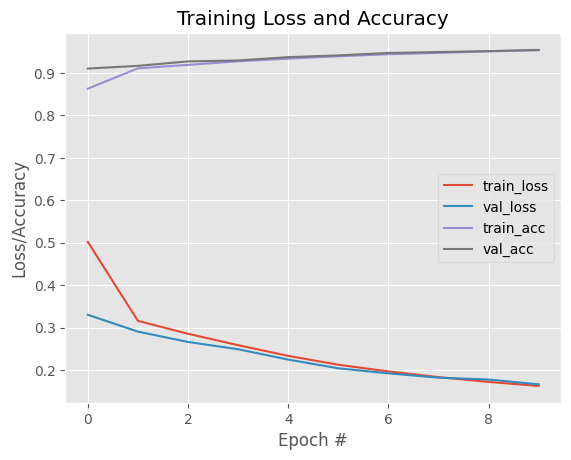

In [22]:
activation_function = "elu"
learning_rate = 0.1
lr_decay = 1e-3
num_epochs = 10
batch_size = 128
train_network_decay_fnact(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

# Vamos a probar con la Sigmoide

<img src="https://image.ibb.co/cMMqJ8/act_fn_sigmoid.png" alt="act_fn_sigmoid" border="0" height="250">

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO]: Entrenando red neuronal...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6236 - loss: 1.6020 - val_accuracy: 0.8608 - val_loss: 0.6516
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8693 - loss: 0.5801 - val_accuracy: 0.8875 - val_loss: 0.4488
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8889 - loss: 0.4297 - val_accuracy: 0.8997 - val_loss: 0.3791
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8979 - loss: 0.3766 - val_accuracy: 0.9072 - val_loss: 0.3421
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9051 - loss: 0.3445 - val_accuracy: 0.9130 - val_loss: 0.3180
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9124 - loss: 0.3152 - val_accuracy: 0.9168 - val_loss: 0.3001
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9179 - loss: 0.2968 - val_accuracy: 0.9217 - val_loss: 0.2864
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.917

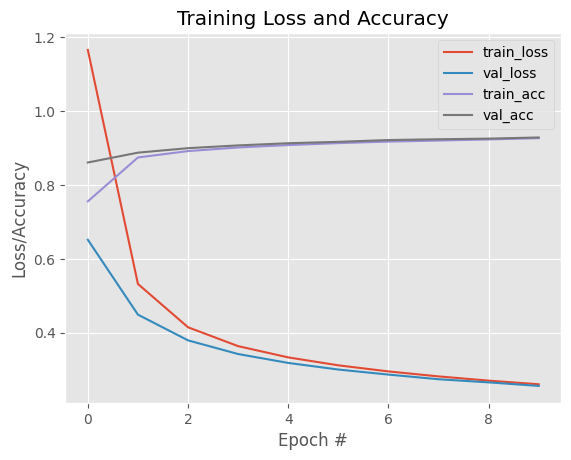

In [23]:
# probamos la sigmoid
activation_function = "sigmoid"
learning_rate = 0.1
lr_decay = 1e-3
num_epochs = 10
batch_size = 128
train_network_decay_fnact(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

# Veamos con la tanh

<img src="https://image.ibb.co/haCKBT/act_fn_tanh.png" alt="act_fn_tanh" border="0" height="250">

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO]: Entrenando red neuronal...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7785 - loss: 0.8408 - val_accuracy: 0.9060 - val_loss: 0.3402
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9103 - loss: 0.3223 - val_accuracy: 0.9213 - val_loss: 0.2781
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9230 - loss: 0.2731 - val_accuracy: 0.9305 - val_loss: 0.2461
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9333 - loss: 0.2370 - val_accuracy: 0.9345 - val_loss: 0.2272
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9385 - loss: 0.2163 - val_accuracy: 0.9418 - val_loss: 0.2088
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9455 - loss: 0.1959 - val_accuracy: 0.9445 - val_loss: 0.1951
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9497 - loss: 0.1824 - val_accuracy: 0.9467 - val_loss: 0.1843
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.951

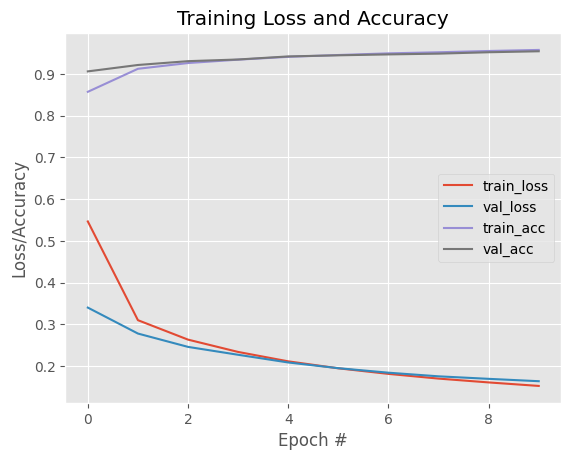

In [25]:
# probamos la tanh
activation_function = "tanh"
learning_rate = 0.1
lr_decay = 1e-3
num_epochs = 10
batch_size = 128
train_network_decay_fnact(activation_function, learning_rate, lr_decay, batch_size, num_epochs)


Probemos a cambiar la inicialización de la bias, en vez de a 0s, a 1s para ver si tenemos algún cambio

In [26]:

# definimos la función para entrenar nuestra red con los parámetros deseados
def train_network_decay_fnact_b1(activation_function, learning_rate, lr_decay, batch_size, num_epochs):

  # Implementamos la red empleando Keras
  model = Sequential() # Instancia de modelo API secuencial #(X)
  model.add(Flatten()) # Estiramos los datos en forma de vector como entrada a nuestro Perceptrón Simple #(X)
  model.add(Dense(32, input_shape=(784,), activation=activation_function))  ##Añadimos una capa con 32 neuronas y añadimos una función de activacion
  model.add(Dense(10, input_shape=(784,), activation="softmax")) # Construimos nuestro Perceptrón simple con una única capa Dense #(X)
  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  opt = SGD(learning_rate=learning_rate)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])  #(X)

  # Entrenando la solución
  H = model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=num_epochs, batch_size=batch_size)  #(X)

  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x_te, batch_size=batch_size)  #(X)
  print(classification_report(y_te.argmax(axis=1), predictions.argmax(axis=1)))

  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO]: Entrenando red neuronal...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7840 - loss: 0.8132 - val_accuracy: 0.9093 - val_loss: 0.3279
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9100 - loss: 0.3204 - val_accuracy: 0.9262 - val_loss: 0.2684
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9251 - loss: 0.2687 - val_accuracy: 0.9335 - val_loss: 0.2366
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9340 - loss: 0.2335 - val_accuracy: 0.9403 - val_loss: 0.2152
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9387 - loss: 0.2205 - val_accuracy: 0.9450 - val_loss: 0.1984
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9457 - loss: 0.1952 - val_accuracy: 0.9472 - val_loss: 0.1887
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9488 - loss: 0.1810 - val_accuracy: 0.9502 - val_loss: 0.1784
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.951

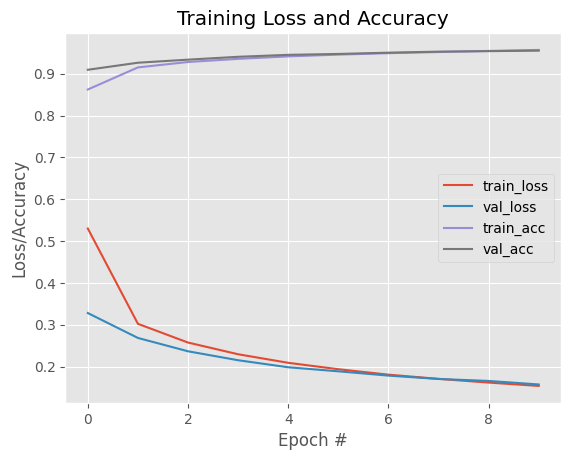

In [27]:
# probamos la tanh y bias 1 en vez de 0
activation_function = tf.nn.tanh
learning_rate = 0.1
lr_decay = 1e-3
num_epochs = 10
batch_size = 128
train_network_decay_fnact_b1(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

También podemos a cambiar la función de pérdidas, de la cross-entropy al error cuadrático medio:

In [ ]:
# definimos la función para entrenar nuestra red con los parámetros deseados
def train_network_decay_fnact_b1_mse(activation_function, learning_rate, lr_decay, batch_size, num_epochs):

  # Implementamos la red empleando Keras
  model = Sequential() # Instancia de modelo API secuencial #(X)
  model.add(Flatten()) # Estiramos los datos en forma de vector como entrada a nuestro Perceptrón Simple #(X)
  model.add(Dense(32, activation=activation_function,  kernel_initializer='random_uniform', bias_initializer='ones')) # Añadimos una capa con 32 neuronas y añadimos una función de activacion
  model.add(Dense(10, input_shape=(784,), activation="softmax")) # Construimos nuestro Perceptrón simple con una única capa Dense #(X)
  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  ## Code ##

  # Entrenando la solución
  H = model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=num_epochs, batch_size=batch_size)  #(X)

  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x_te, batch_size=batch_size)  #(X)
  print(classification_report(y_te.argmax(axis=1), predictions.argmax(axis=1)))

  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

In [ ]:
# probamos la tanh, bias = 1 y loss_fn = mse
activation_function = ## Code ##
learning_rate = 0.1
lr_decay = 1e-3
num_epochs = 10
batch_size = 128
train_network_decay_fnact_b1_mse(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

¿Os dáis cuenta? Hay 3 cosas que van íntimamente ligadas y de las que debemos ocuparnos para encontrar una buena configuración:

* **La función de activación**
* **La función de pérdidas**
* **La inicialización de los pesos y bias** (menos importante si hay datos suficientes)


# Atención:

### Como he comentado antes, en el caso de las capas de salida, practicamente siempre se utiliza la función de activación de tipo softmax, ya que es capaz de dar una probabilidad a cada clase, haciendo que todas ellas sumen 1. Esto en el caso de clasificación, porque en regresión, la última capa tiene tantas neuronas como valores queramos predecir y función de activación LINEAL, es decir, NINGUNA.

Como esto puede parecer un poco complicado, os voy a escribir aquí la receta que sigo yo y que hasta ahora me ha dado buenos resultados:

# Receta

* Empezar usando un learning rate de 0.01 o 0.001, y observar qué pasa.

* Si la red entrena (va convergiendo) pero es lenta, podéis probar a aumentar un poco el learning rate.

* Si la red no converge y se compora de forma caótica, disminuid el learning rate.

* En clasificación, usad la softmax. No uséis la sigmoide a menos que sepáis lo que estáis haciendo, en la práctica no suele dar buenos resultados. En regresión, recordad que la última capa NO TIENE functión de activación o si habéis normalizado las etiquetas entre 0 y 1 podéis utilizar la función sigmoid.
